# TPCH all-table multi-stream analysis

Aggregate TPCH-all query timings across every stream run under `results/tpch_all` and prepare per-query statistics/figures.

In [17]:

# --- Bootstrap imports and notebook paths ---
import sys
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NB_DIR = Path.cwd()
PROJ_ROOT = NB_DIR.parent
RESULTS_ROOT = PROJ_ROOT / "results" / "tpch_all"
FIGURES_DIR = NB_DIR / "figures"

for path in (NB_DIR, PROJ_ROOT):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:

ENGINE_COLORS = {
    "delta": "#1b9e77",
    "hudi": "#d95f02",
    "iceberg": "#7570b3",
}

METRIC_CANDIDATES = [
    "elapsedTime_s",
    "executorRunTime_s",
    "executorCpuTime_s",
    "bytes_scanned",
    "bytes_scanned_ev",
    "bytes_input_files",
]


def normalize_query_label(value: str) -> str:
    if not isinstance(value, str):
        return value
    base = value.strip().lower()
    if base.endswith('.sql'):
        base = base[:-4]
    base = base.replace('query_', 'q')
    base = base.replace('tpch_', 'q')
    base = base.upper()
    if not base.startswith('Q'):
        return value
    digits = ''.join(ch for ch in base if ch.isdigit())
    if digits:
        return f"Q{int(digits):02d}"
    return base


def load_tpch_all_results(root: Path = RESULTS_ROOT) -> pd.DataFrame:
    frames = []
    root = Path(root)
    if not root.exists():
        raise FileNotFoundError(f"Missing TPCH-all results directory: {root}")
    for engine_dir in sorted(p for p in root.iterdir() if p.is_dir()):
        engine = engine_dir.name
        for stream_dir in sorted(p for p in engine_dir.glob('stream_*') if p.is_dir()):
            for run_dir in sorted(p for p in stream_dir.iterdir() if p.is_dir()):
                csv_path = run_dir / 'results.csv'
                if not csv_path.exists():
                    continue
                df = pd.read_csv(csv_path)
                if 'engine' not in df.columns or df['engine'].isna().all():
                    df['engine'] = engine
                df['engine'] = df['engine'].fillna(engine)
                df['stream'] = stream_dir.name
                df['run_ts'] = run_dir.name
                df['run_id'] = f"{stream_dir.name}/{run_dir.name}"
                df['result_path'] = csv_path.relative_to(PROJ_ROOT).as_posix()
                frames.append(df)
    if not frames:
        raise SystemExit("No TPCH-all result CSVs found.")
    data = pd.concat(frames, ignore_index=True)
    numeric_cols = [
        'bytesRead', 'elapsedTime_s', 'executorRunTime_s', 'executorCpuTime_s',
        'bytes_input_files', 'files_scanned', 'bytes_scanned',
        'bytesRead_ev', 'files_scanned_ev', 'bytes_scanned_ev',
        'executorRunTime_s_ev', 'executorCpuTime_s_ev'
    ]
    for col in numeric_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
    data['query'] = data['query'].apply(normalize_query_label)
    data['engine'] = data['engine'].str.lower()
    data['engine'] = data['engine'].replace({'delta-lake': 'delta'})
    return data


def sort_query_order(labels):
    def key_fn(label):
        label = str(label)
        if label.upper().startswith('Q'):
            digits = ''.join(ch for ch in label[1:] if ch.isdigit())
            if digits:
                return int(digits)
        return float('inf')
    return sorted(labels, key=key_fn)


In [19]:

all_results = load_tpch_all_results()
metrics_available = [m for m in METRIC_CANDIDATES if m in all_results.columns]
if not metrics_available:
    raise SystemExit("Expected metrics missing from combined results.")

all_results['engine'] = all_results['engine'].astype('category')
all_results['query'] = all_results['query'].astype('category')

query_order = sort_query_order(all_results['query'].unique())
engine_order = sorted(all_results['engine'].unique())

print(f"Loaded {len(all_results):,} rows · engines={engine_order} · queries={len(query_order)}")
all_results.head()


Loaded 600 rows · engines=['delta', 'hudi', 'iceberg'] · queries=21


,engine,stream,query,bytesRead,elapsedTime_s,executorRunTime_s,executorCpuTime_s,bytes_input_files,files_scanned,bytes_scanned,bytesRead_ev,files_scanned_ev,bytes_scanned_ev,executorRunTime_s_ev,executorCpuTime_s_ev,run_ts,run_id,result_path
0,delta,stream_1,Q01,0,10.430,454.138,326.894,4284.633,0,0.0,60853.168,0,60853.168,4575.251,3260.663,20251109_154538,stream_1/20251109_154538,results/tpch_all/delta/stream_1/20251109_15453...
1,delta,stream_1,Q02,0,3.196,148.028,87.027,4463.072,0,0.0,14099.880,0,14099.880,1377.440,820.135,20251109_154538,stream_1/20251109_154538,results/tpch_all/delta/stream_1/20251109_15453...
2,delta,stream_1,Q03,0,6.154,292.932,210.161,4463.072,0,0.0,21039.317,0,21039.317,2839.040,2047.138,20251109_154538,stream_1/20251109_154538,results/tpch_all/delta/stream_1/20251109_15453...
3,delta,stream_1,Q04,0,4.646,196.320,132.735,4475.266,0,0.0,19261.830,0,19261.830,1935.721,1302.741,20251109_154538,stream_1/20251109_154538,results/tpch_all/delta/stream_1/20251109_15453...
4,delta,stream_1,Q05,0,1.968,47.354,42.076,694.418,0,0.0,4938.798,0,4938.798,297.225,244.125,20251109_154538,stream_1/20251109_154538,results/tpch_all/delta/stream_1/20251109_15453...


In [22]:

agg_dict = {metric: 'mean' for metric in metrics_available}
agg_dict['run_id'] = 'nunique'
agg_dict['stream'] = 'nunique'
# per_query_summary = (all_results
#                       .groupby(['engine', 'query'])
#                       .agg(agg_dict)
#                       .rename(columns={'run_id': 'runs', 'stream': 'streams'})
#                       .reset_index())

# per_query_summary['samples'] = (all_results
#                                 .groupby(['engine', 'query'])['elapsedTime_s']
#                                 .transform('count')
#                                 .values)

# per_query_summary.sort_values(['query', 'engine'])


samples = (all_results
    .groupby(['engine', 'query'])['elapsedTime_s']
    .count()
    .reset_index(name='samples'))

per_query_summary = (all_results
    .groupby(['engine', 'query'])
    .agg(agg_dict)
    .rename(columns={'run_id': 'runs', 'stream': 'streams'})
    .reset_index())

per_query_summary = per_query_summary.merge(samples,
                                            on=['engine', 'query'],
                                            how='left')

/tmp/ipykernel_1881175/1566456872.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['engine', 'query'])['elapsedTime_s']
/tmp/ipykernel_1881175/1566456872.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['engine', 'query'])


In [23]:
agg_dict = {metric: 'mean' for metric in metrics_available}
agg_dict['run_id'] = 'nunique'
agg_dict['stream'] = 'nunique'
per_query_summary = (all_results
                      .groupby(['engine', 'query'], observed=True)
                      .agg(agg_dict)
                      .rename(columns={'run_id': 'runs', 'stream': 'streams'})
                      .reset_index())

sample_counts = (all_results
                 .groupby(['engine', 'query'], observed=True)
                 .size()
                 .reset_index(name='samples'))

per_query_summary = per_query_summary.merge(sample_counts, on=['engine', 'query'], how='left')

per_query_summary.sort_values(['query', 'engine'])


,engine,query,elapsedTime_s,executorRunTime_s,executorCpuTime_s,bytes_scanned,bytes_scanned_ev,bytes_input_files,runs,streams,samples
0,delta,Q01,4.312500,95.059400,61.594700,0.0,25895.39120,4143.356800,10,10,10
21,hudi,Q01,4.473100,214.700000,141.304800,0.0,19826.32980,3755.211000,10,10,10
42,iceberg,Q01,5.631400,272.132800,168.660400,0.0,80540.30820,0.000000,10,10,10
1,delta,Q02,3.921125,178.495250,119.155875,0.0,21645.75475,3778.111500,8,8,8
22,hudi,Q02,4.161125,190.691500,144.513250,0.0,16848.45125,3412.562625,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...
40,hudi,Q21,3.341778,149.880889,102.578556,0.0,13257.91600,3440.581333,9,9,9
61,iceberg,Q21,3.469667,179.298000,118.649889,0.0,30039.13800,0.000000,9,9,9
20,delta,Q22,4.226200,191.359600,122.148800,0.0,25023.48870,3679.949600,10,10,10
41,hudi,Q22,4.009300,174.248000,122.783800,0.0,18902.12290,3294.409800,10,10,10


In [24]:

def plot_query_boxplots(df, metric, engines):
    queries = sort_query_order(df['query'].unique())
    n = len(queries)
    ncols = 4 if n >= 8 else max(1, min(3, n))
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows), squeeze=False, sharey=True)
    metric_label = metric.replace('_', ' ')
    for idx, query in enumerate(queries):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        subset = df[df['query'] == query]
        groups, labels, colors = [], [], []
        for eng in engines:
            vals = subset.loc[subset['engine'] == eng, metric].dropna()
            if vals.empty:
                continue
            groups.append(vals)
            labels.append(eng)
            colors.append(ENGINE_COLORS.get(eng, '#555555'))
        if not groups:
            ax.set_axis_off()
            continue
        box = ax.boxplot(groups, labels=labels, patch_artist=True, widths=0.6)
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.65)
        ax.set_title(query)
        if c == 0:
            ax.set_ylabel(metric_label)
        ax.grid(True, axis='y', linestyle=':', alpha=0.35)
    for idx in range(n, nrows * ncols):
        r, c = divmod(idx, ncols)
        axes[r][c].set_axis_off()
    fig.tight_layout()
    return fig


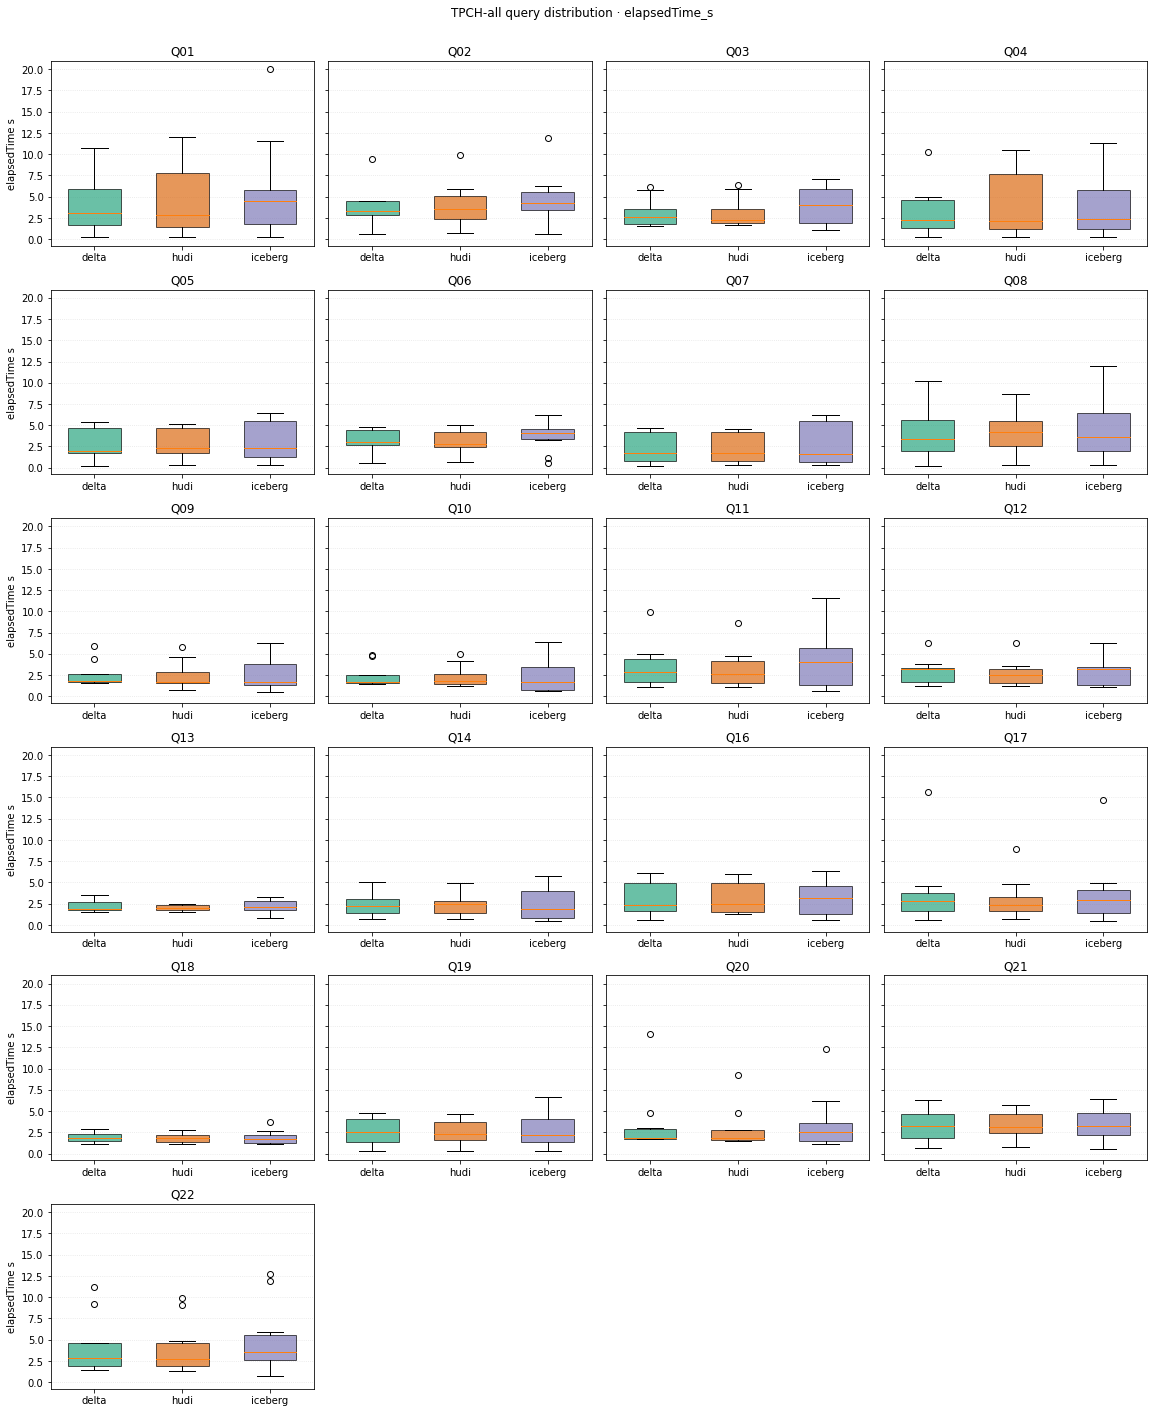

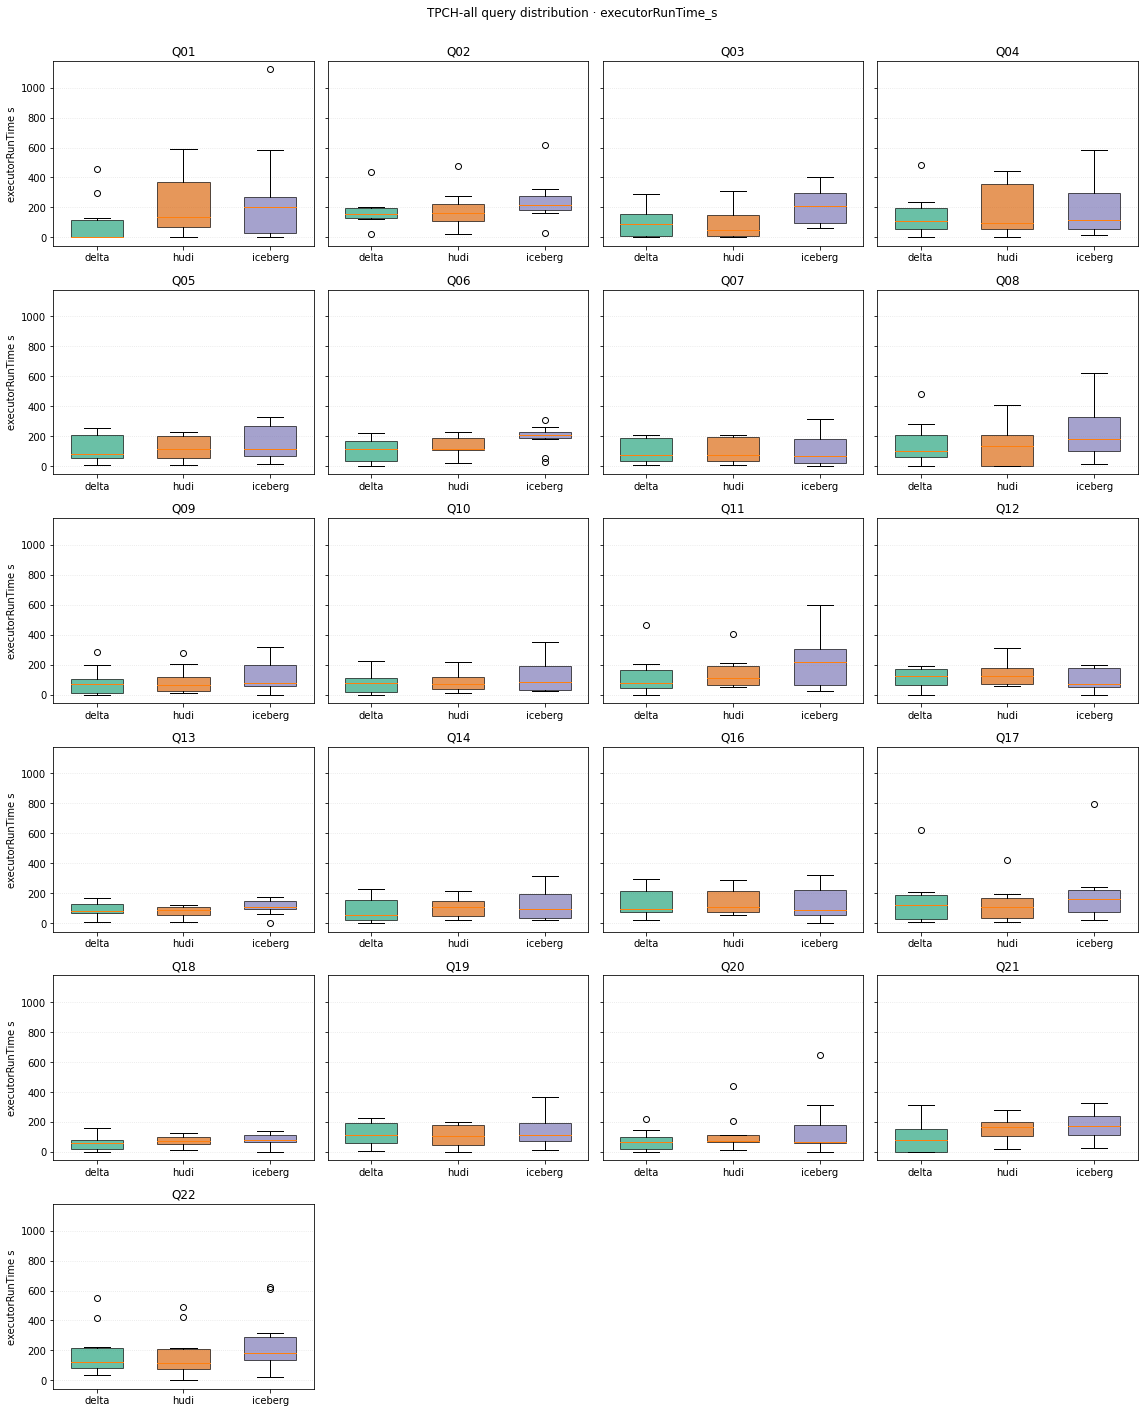

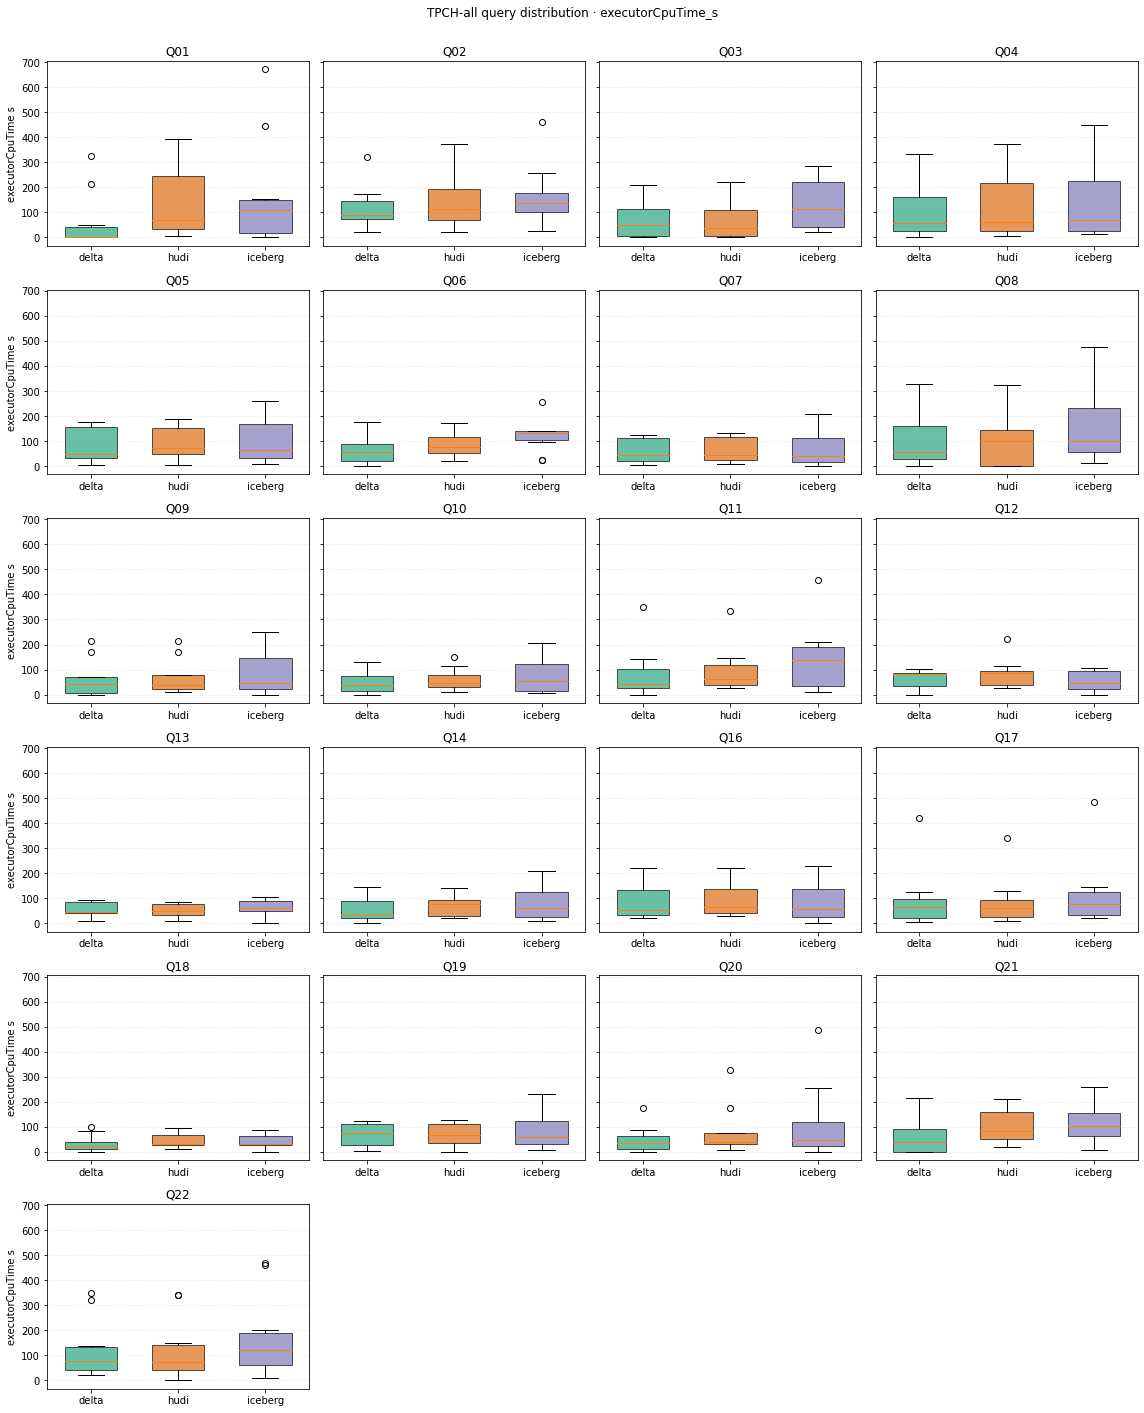

In [25]:

for metric in metrics_available[:3]:
    fig = plot_query_boxplots(all_results, metric, engine_order)
    fig.suptitle(f"TPCH-all query distribution · {metric}", y=1.02)
    out_path = FIGURES_DIR / f"tpch_all_{metric}_boxplots"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path.with_suffix('.png'), dpi=160)
    fig.savefig(out_path.with_suffix('.pdf'))
    plt.show()


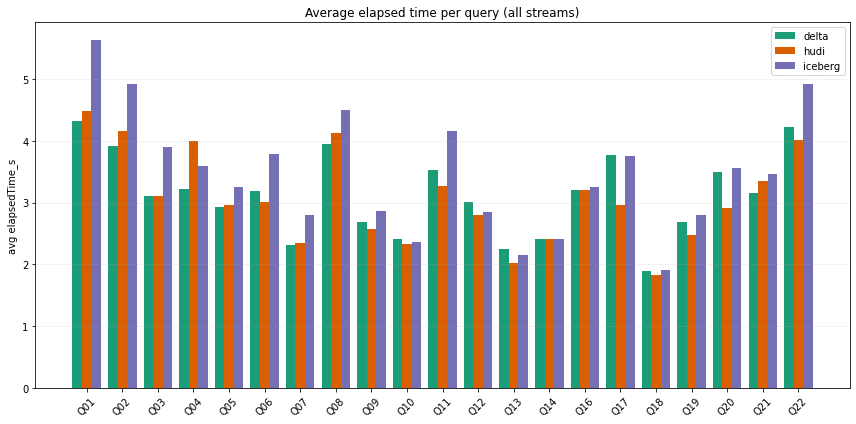

In [26]:

metric = 'elapsedTime_s'
pivot = per_query_summary.pivot(index='query', columns='engine', values=metric)
if not pivot.empty:
    pivot = pivot.loc[sort_query_order(pivot.index)]
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.8 / max(1, len(engine_order))
    x = np.arange(len(pivot.index))
    for idx, eng in enumerate(engine_order):
        if eng not in pivot.columns:
            continue
        values = pivot[eng]
        ax.bar(x + idx * width, values, width=width, label=eng, color=ENGINE_COLORS.get(eng, None))
    ax.set_xticks(x + width * (len(engine_order)-1) / 2)
    ax.set_xticklabels(pivot.index, rotation=45)
    ax.set_ylabel('avg elapsedTime_s')
    ax.set_title('Average elapsed time per query (all streams)')
    ax.legend()
    ax.grid(True, axis='y', linestyle=':', alpha=0.5)
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / 'tpch_all_elapsed_avg.png', dpi=160)
    plt.show()
